## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

#### Find corners of the calibration images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Create the test_images_output directory.
if not os.path.exists("drawn_chessboards_corners_output"):
    os.makedirs("drawn_chessboards_corners_output")

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        drawn_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Extract filename from path 
        # (See https://stackoverflow.com/questions/8384737/extract-file-name-from-path-no-matter-what-the-os-path-format)
        head, tail = os.path.split(fname)
        # Save the drawn images to a folder to visualize the result
        mpimg.imsave("drawn_chessboards_corners_output/" + tail, img)

#### Correct for distortion

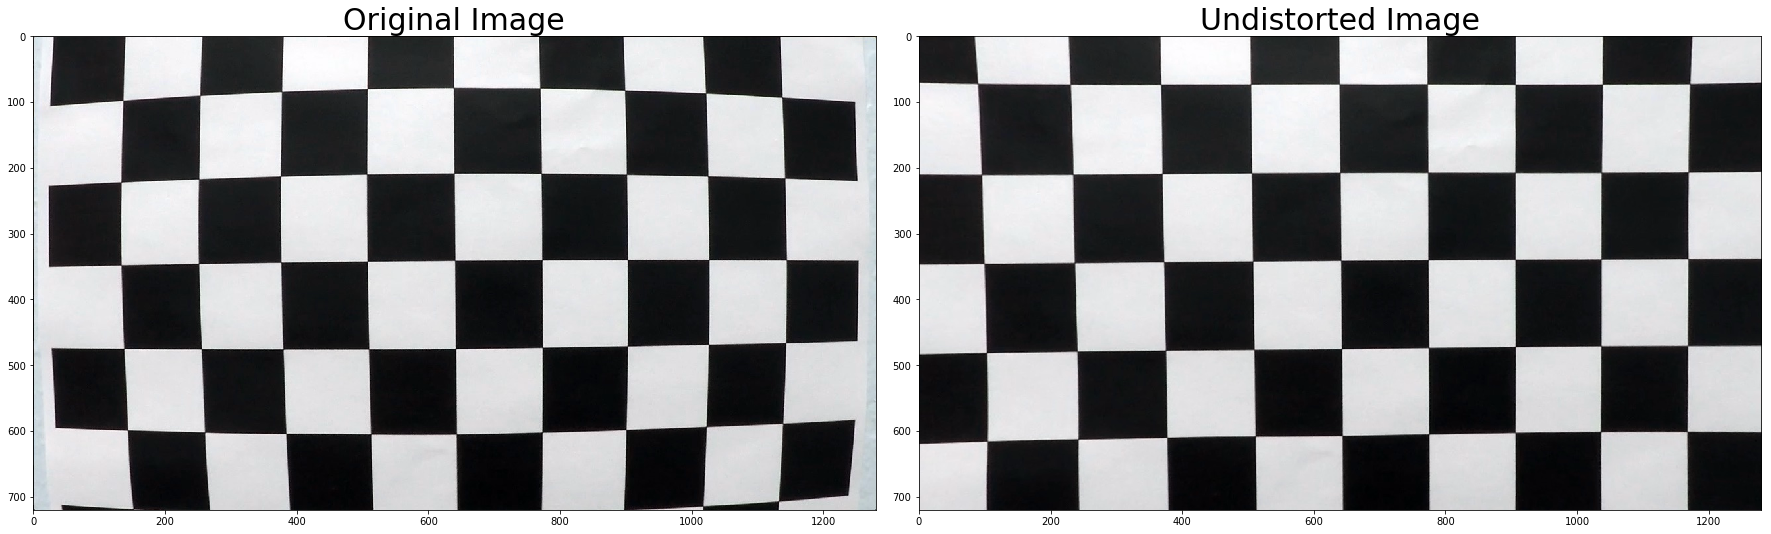

In [3]:
'''
Take an image, object points and image points and perform 
the camera calibration and image distortion correction. 

Return the undistorted image
'''
def cal_undistort(img, objpoints, imgpoints):
    # Calibrate the camera given object points, image points and the shape of the grayscale image.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

distorted_image = cv2.imread('./camera_cal/calibration1.jpg')
# Get the undistorted image
undistorted = cal_undistort(distorted_image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(distorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
f.set_facecolor("white")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/undistort output.jpg")

## Pipeline

#### Define threshold functions

In [4]:
'''
Apply Sobel x or y, then take an absolute value and apply a threshold.

'''
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient=='x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return this mask as binary_output image
    return grad_binary

'''
Apply Sobel x and y, then compute the magnitude of the gradient and apply a threshold.
'''
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    grad_mag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(grad_mag)
    mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return mag_binary

'''
Apply Sobel x and y, then compute the direction of the gradient and apply a threshold.
'''
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return dir_binary

#### Create a thresholded binary image

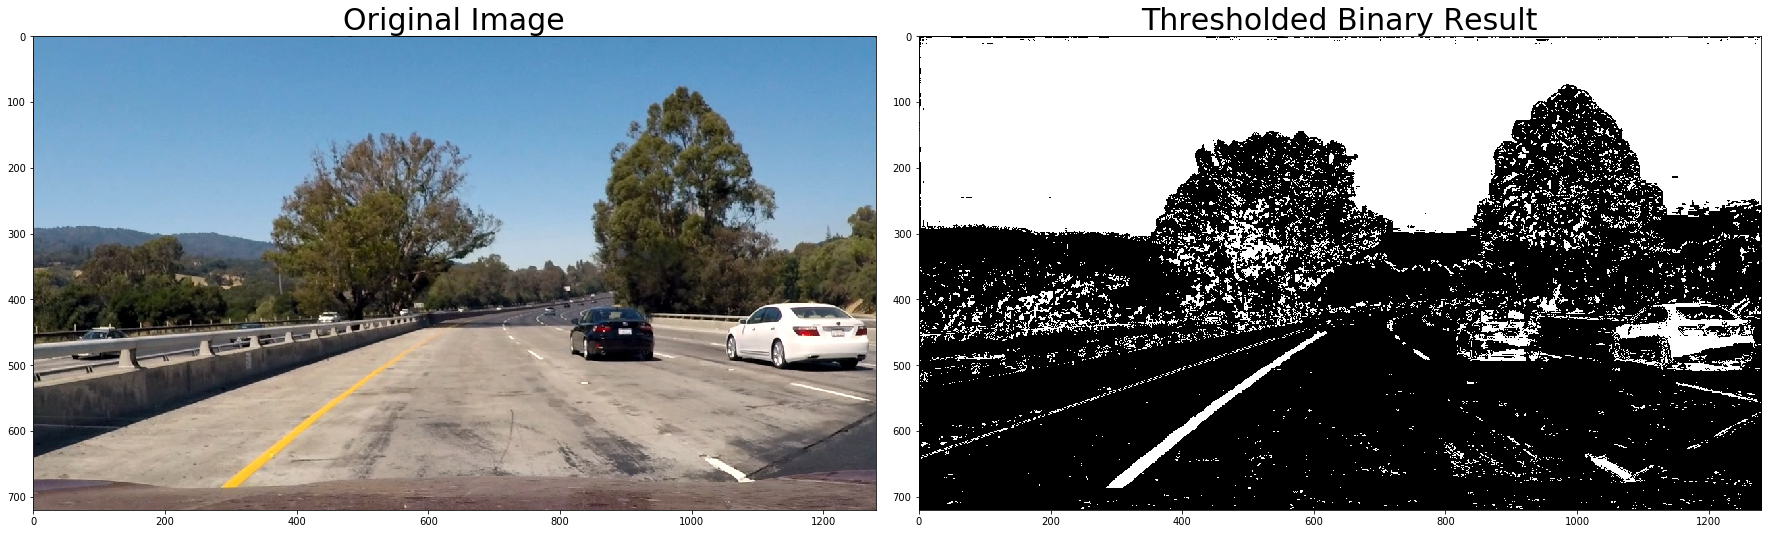

In [5]:
# Edit this function to create your own pipeline.
'''
Use color transforms and gradients to create a thresholded binary image.
'''
def threshold_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Get Sobel thresholds
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    # Get gradient magnitude threshold
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    # Get gradient direction threshold
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))    
    
    # Threshold color channel
    s_thresh_min = 110
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(gradx), gradx, s_binary)) * 255
    combined = np.zeros_like(dir_binary)
    combined[(s_binary == 1) | ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined
    
# Load a test image
image = mpimg.imread('./test_images/test1.jpg')    

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements
    
# Apply the threshold binary function
result = threshold_binary(image)

mpimg.imsave("output_images/binary_combo_example.jpg", result, cmap='gray')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded Binary Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Perspective Transform

In [6]:
# Load an image with strainght lines to perform a perspective transform
image_undist = mpimg.imread('./test_images/straight_lines1.jpg')

img_size = (image_undist.shape[1], image_undist.shape[0])
#print(image_undist.shape[1])
#print(image_undist.shape[0])

# Source and destination points
src = np.float32(
    [[(img_size[0] / 2 - 59), (img_size[1] / 2 + 100)],  # Top left
    [(img_size[0] / 6 - 10), img_size[1]],  # Bottom left
    [(img_size[0] * 5 / 6 + 40), img_size[1]],  # Bottom right
    [(img_size[0] / 2 + 61), (img_size[1] / 2 + 100)]])  # Top right    
dst = np.float32(
    [[(img_size[0] / 4), 0],  # Top left
    [(img_size[0] / 4), img_size[1]],  # Bottom left
    [(img_size[0] * 3 / 4), img_size[1]],  # Bottom right
    [(img_size[0] * 3 / 4), 0]])  # Top right

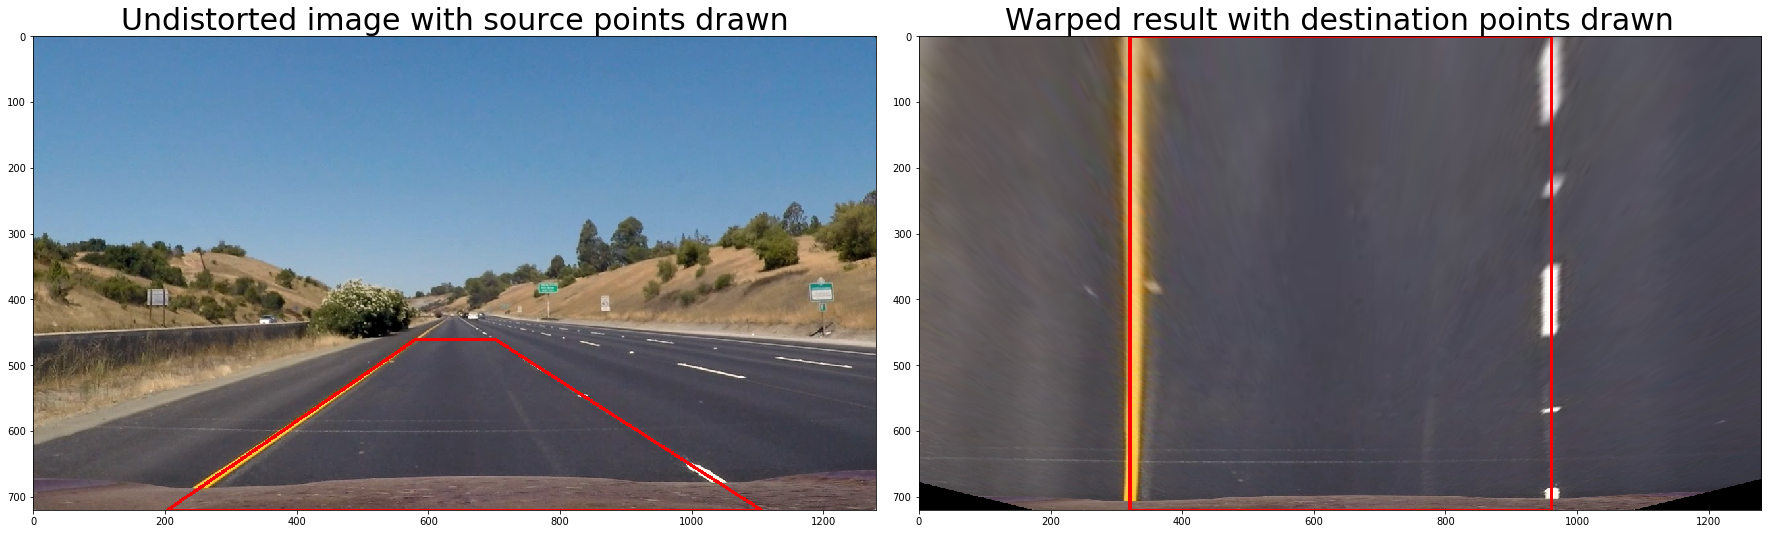

In [7]:
# Define a perspective transform function
def warper(img, src, dst):
    # Given source and destination points, compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image, given the perspective transform M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

# Get the warped image
warped_image = warper(image_undist, src, dst)

# Line thickness 
line_thickness = 4

# Draw lines in the original image
cv2.line(image_undist, (src[0][0], src[0][1]), (src[1][0], src[1][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(image_undist, (src[1][0], src[1][1]), (src[2][0], src[2][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(image_undist, (src[2][0], src[2][1]), (src[3][0], src[3][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(image_undist, (src[3][0], src[3][1]), (src[0][0], src[0][1]), (255, 0, 0), thickness=line_thickness)
# Draw lines in the warped image
cv2.line(warped_image, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(warped_image, (dst[1][0], dst[1][1]), (dst[2][0], dst[2][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(warped_image, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(warped_image, (dst[3][0], dst[3][1]), (dst[0][0], dst[0][1]), (255, 0, 0), thickness=line_thickness)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_undist)
ax1.set_title('Undistorted image with source points drawn', fontsize=30)

ax2.imshow(warped_image)
ax2.set_title('Warped result with destination points drawn', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/warped_straight_lines.jpg")

#### Create a binary warped image

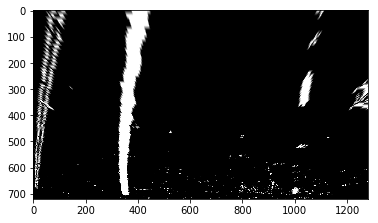

In [8]:
# Create a binary warped image. 
# result is the thresholded binary image found on cell 5 above
binary_warped = warper(result, src, dst)

plt.imshow(binary_warped, cmap='gray')

# Save on disk the warped binary image
mpimg.imsave("output_images/binary_warped.jpg", binary_warped, cmap='gray')

#### Locate the lane lines

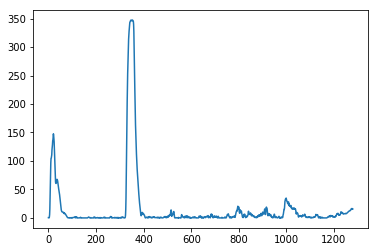

In [9]:
# Find peaks in a histogram
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


# Create histogram of image binary activations
histogram = hist(binary_warped)

# Visualize the resulting histogram
plt.plot(histogram)

#### Implement sliding windows

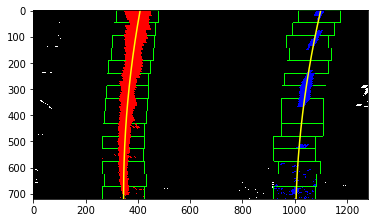

In [10]:
# Determine where the lane lines go
def find_lane_pixels(binary_warped):    
    # Create a histogram of the bottom half of the image
    histogram = hist(binary_warped)        
    # Convert the binary warped image to use the correct data type
    # See https://knowledge.udacity.com/questions/272574
    new_warped = binary_warped.astype(np.uint8)*255
    # Create an output image to draw on and visualize the result later on
    out_img = np.dstack((new_warped, new_warped, new_warped))
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin       
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# Find lane pixels
def lane_pixels(binary_warped, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
                
    return ploty, left_fit, right_fit


# Fit a polynomial to all the relevant pixels found in the sliding windows
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    ploty, left_fit, right_fit = lane_pixels(binary_warped, leftx, lefty, rightx, righty)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img

def visualize_lanes(left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img):
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    
    #_left = left_fitx[len(left_fitx) - 1]
    #_right = right_fitx[len(right_fitx) - 1]
    
    # turn x_left, x_right

left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img = fit_polynomial(binary_warped)
# Visualize the lines in the output image 
visualize_lanes(left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img)

plt.imshow(out_img)

# Save on disk the image with lines drawn
plt.savefig("output_images/color_fit_lines.jpg")

### Measure the curvature 

In [11]:
def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    ploty, left_fit_cr, right_fit_cr = lane_pixels(binary_warped, leftx, lefty, rightx, righty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define the y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty * ym_per_pix)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(binary_warped)

print(left_curverad, right_curverad)

4052.22223836 3954.84417256


### Radius of curvature and position of the vehicle

In [12]:
'''

#test_image = mpimg.imread('./test_images/straight_lines1.jpg')
undist1 = mpimg.imread('./test_images/test2.jpg')

# Apply the threshold binary function
threshold_test_image = threshold_binary(undist1)

# Create a binary warped image
binary_warped_test_image = warper(threshold_test_image, src, dst)

# Create histogram of image binary activations
histogram = hist(binary_warped_test_image)

# Calculate the radius of curvature in pixels for both lane lines
left_curverad_test_image, right_curverad_test_image = measure_curvature_pixels(binary_warped_test_image)

# Get the output image 
#x_left_test_image, x_right_test_image = fit_polynomial(binary_warped)

left_fitx_test, leftx_test, lefty_test, right_fitx_test, rightx_test, righty_test, ploty_test, output_img = fit_polynomial(binary_warped_test_image)
x_left_test_image = left_fitx_test[len(left_fitx_test) - 1]
x_right_test_image = right_fitx_test[len(right_fitx_test) - 1]

# Colors in the left and right lane regions
undist1[lefty_test, leftx_test] = [255, 0, 0]
undist1[righty_test, rightx_test] = [0, 0, 255]

xm_per_pix = 3.7/700 # meters per pixel in x dimension

print(x_left_test_image)
print(x_right_test_image)

#x_left = x_left * xm_per_pix
#x_right = x_right * xm_per_pix

half_length = (x_right_test_image + x_left_test_image) / 2
print(half_length)

center_of_image = (src[1][0] + src[2][0]) / 2
print(center_of_image)

#distance = str(abs((center_of_image - half_length) * xm_per_pix))
distance = '%.2f'%(abs((center_of_image - half_length) * xm_per_pix))
position = 'left'
if half_length > center_of_image:
    position = 'right'
    
# Text to show on the image for the curvature
curvature = int(np.mean([left_curverad_test_image, right_curverad_test_image]))
text = 'Radius of curvature = ' + str(curvature) + '(m)'
#text = 'Radius of curvature = ' + str(curvature) + '(m)'

# Parameters for 'putText'
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (100,80)
fontScale              = 2
fontColor              = (255,255,255)
lineType               = 4

cv2.putText(undist1,
    text, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

other_bottomLeftCornerOfText = (100,140)

other_text = 'Vehicle is ' + distance + 'm ' + position + ' of center'
cv2.putText(undist1,
    other_text, 
    other_bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)

#Display the image
#cv2.imshow("img",image_undist)


plt.imshow(undist1)

'''

'\n\n#test_image = mpimg.imread(\'./test_images/straight_lines1.jpg\')\nundist1 = mpimg.imread(\'./test_images/test2.jpg\')\n\n# Apply the threshold binary function\nthreshold_test_image = threshold_binary(undist1)\n\n# Create a binary warped image\nbinary_warped_test_image = warper(threshold_test_image, src, dst)\n\n# Create histogram of image binary activations\nhistogram = hist(binary_warped_test_image)\n\n# Calculate the radius of curvature in pixels for both lane lines\nleft_curverad_test_image, right_curverad_test_image = measure_curvature_pixels(binary_warped_test_image)\n\n# Get the output image \n#x_left_test_image, x_right_test_image = fit_polynomial(binary_warped)\n\nleft_fitx_test, leftx_test, lefty_test, right_fitx_test, rightx_test, righty_test, ploty_test, output_img = fit_polynomial(binary_warped_test_image)\nx_left_test_image = left_fitx_test[len(left_fitx_test) - 1]\nx_right_test_image = right_fitx_test[len(right_fitx_test) - 1]\n\n# Colors in the left and right lane 

In [13]:
'''
Draw your measurement onto the road to identify the lane lines. 

'''
def draw(warped_binary, original_image, src, dst, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    # Colors in the left and right lane regions
    #original_image[lefty, leftx] = [255, 0, 0]
    #original_image[righty, rightx] = [0, 0, 255]

    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    x_left = left_fitx[len(left_fitx) - 1]
    x_right = right_fitx[len(right_fitx) - 1]
    print('x left ', x_left)
    print('x right ', x_right)

    
    half_length = (x_right + x_left) / 2
    print('half length ', half_length)

    center_of_image = (src[1][0] + src[2][0]) / 2
    print('center ', center_of_image)

    #distance = str(abs((center_of_image - half_length) * xm_per_pix))
    distance = '%.2f'%(abs((center_of_image - half_length) * xm_per_pix))
    position = 'left'
    if half_length > center_of_image:
        position = 'right'
        
    # Calculate the radius of curvature in pixels for both lane lines
    left_curverad, right_curverad = measure_curvature_pixels(warped_binary)
    
    # Text to show on the image for the curvature
    curvature = int(np.mean([left_curverad, right_curverad]))
    text = 'Radius of curvature = ' + str(curvature) + '(m)'
    #text = 'Radius of curvature = ' + str(curvature) + '(m)'

    # Parameters for 'putText'
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,80)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 4

    cv2.putText(result,
        text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    other_bottomLeftCornerOfText = (100,140)

    other_text = 'Vehicle is ' + distance + 'm ' + position + ' of center'
    cv2.putText(result,
        other_text, 
        other_bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    #Display the image
    #cv2.imshow("img",image_undist)

    
    plt.imshow(result)
    

#undist = mpimg.imread('./test_images/test1.jpg')

#undist = mpimg.imread('./test_images/test1.jpg')
#draw(binary_warped, undist1, src, dst, ploty, left_fitx, right_fitx)

x left  339.948117041
x right  985.758027632
half length  662.853072337
center  655.0


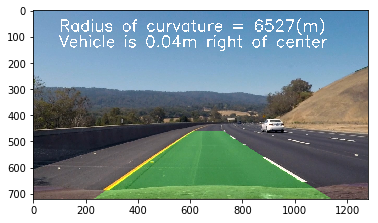

In [14]:
def pipeline(original, src, dst, ):
    # Apply the threshold binary function
    threshold_image = threshold_binary(original)

    # Create a binary warped image
    binary_warped = warper(threshold_image, src, dst)

    # Create histogram of image binary activations
    histogram = hist(binary_warped)

    
    # Calculate the radius of curvature in pixels for both lane lines
    #left_curverad, right_curverad = measure_curvature_pixels(binary_warped)

    # Get the output image 
    #x_left_test_image, x_right_test_image = fit_polynomial(binary_warped)

    
    left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, output_img = fit_polynomial(binary_warped)

    draw(binary_warped, original, src, dst, ploty, left_fitx, right_fitx)

    #plt.imshow(original)
    
original = mpimg.imread('./test_images/test3.jpg')
pipeline(original, src, dst)